In [ ]:
# default_exp RFsimulation

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *
# default_cls_lvl 3

# RFsimulation
> Submodule of `rfml_localization` that provides the ability to simulate an indoor RF propagation environment for the purpose of generating classical measurements (e.ge., ToA/TDoA, RSS/DRSS, and AoA/DAoA) to test optimization methods for localization purposes.  

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from itertools import combinations
from sklearn.utils import check_array

In [ ]:
#export
class RFchannel:
    """
    The class enables the creation of a parameterized RF channel 
    environment.  The default channel parameters are based on academic
    literature that represent, in average, a typical office building
    with an exponential distribution of multipath clusters, a path loss
    characterized by a log-Gaussian distribution around a distant 
    dependent mean, and a Laplacian distribution with respect to angle
    of arrival.  Using these parameters plus user input, there are a
    number of functions within the class enabling simulation of 
    measurements. 
    
    The methods within this class can be used as stand-alone functions
    if pulled out of the class.  Parameters that are set by the class
    instantiation are noted as such.
    
    __Parameters__
    
    Multipath parameters for temporal measurements (e.g. ToA/TDoA) as 
    described by ([^1]) are:
    
    >__maxSpreadT__ : float, default = 100
    >- Max delay spread to check (ns)
    >
    >__PoissonInvLambda__ : float, default = 50 
    >- Poisson Cluster Arrival Parameter (ns)
    >
    >__Poissoninvlambda__ : float, default = 10 
    >- Poisson Multipath Arrival Parameter (ns)
    
    >__PoissonGamma__ : float, default = 50
    >- Amplitude Decay of Cluster
    
    >__Poissongamma__ : float, default = 29
    >-Amplitude Decay of Multipath
        
    Channel gain parameters for power/amplitude measurements (e.g. 
    RSS/DRSS) as described by ([^2]) are:
    
    >__PathLossN__ : float, default = 3.0
    >- Path Loss Exponent (dB)
    >
    >__Xsigma__ : float, default =  7
    >- Std deviation of Gaussian RV (log-normal)
    >
    >__Wavelength__ : float, default = 3.0e8 / 205.267e6 
    >- Frequency dependent (Hz), units of meter
        
    Multipath parameters for spatial measurements (e.g. AoA/DAoA) as
    described by ([^3]) are:
    
    >__AoAsigma__ : float, default = 26*np.pi/180
    >- Std deviation of Laplacian RV (rad)
    
    __Notes__
    
    [^1]: A. A. M. Saleh and R. Valenzuela, "A Statistical Model for
        Indoor Multipath Propagation," in IEEE Journal on Selected 
        Areas in Communications, vol. 5, no. 2, pp. 128-137, February
        1987, doi: 10.1109/JSAC.1987.1146527.
    [^2]: Theodore S. Rappaport's Wireless Communications: Principles
        and Practice by IEEE Press, Inc. Prentic Hall ISBN: 
        0-7803-1167-1. Chapters 3 and 4
    [^3]: Q. H. Spencer, B. D. Jeffs, M. A. Jensen and A. L. 
        Swindlehurst, "Modeling the statistical time and angle of 
        arrival characteristics of an indoor multipath channel," in
        IEEE Journal on Selected Areas in Communications, vol. 18, no. 
        3, pp. 347-360, March 2000, doi: 10.1109/49.840194.    
    """

    def __init__(self, maxSpreadT = 100, PoissonInvLambda = 50, Poissoninvlambda = 10,
                 PoissonGamma = 50, Poissongamma = 29, PathLossN = 3.0, Xsigma = 7, 
                 Wavelength = 3.0e8 / 205.267e6, AoAsigma = 26*np.pi/180):
        self.maxSpreadT=maxSpreadT 
        self.PoissonInvLambda=PoissonInvLambda
        self.Poissoninvlambda=Poissoninvlambda
        self.PoissonGamma=PoissonGamma
        self.Poissongamma=Poissongamma
        self.PathLossN=PathLossN
        self.Xsigma=Xsigma
        self.Wavelength=Wavelength
        self.AoAsigma=AoAsigma 

    def generate_RxTxlocations(self, n_rx=6, areaWL=np.array([20,60]), n_runs=1000,
                               sensor_locs= np.array([[[6.3], [14.1], [7.2], [14.5], [7.5], [13.5]],[[15.3], [15.1], [30.1], [30.5], [44.9], [44.5]]]),
                               rxtx_flag=3, grid_flag=0, seed=None):
        """
        Generate a three dimensional array (cartesian coordinates -- each 
        row a dim) x (sensors -- each col a specific sensor) x (num_runs --
        3rd dimension is number of observations) that provides locations of
        a Tx source and a set of RF sensors across multiple 
        observations/runs. Each column is a sensor (except first col 
        is Tx) location, next col is sensor 1 location, then sensor 2, etc.
        3rd dimension marks either a new or same Rx sensor arrangement 
        (depending on flag) at next observation.  Values are in meters.

        __Parameters__

        >__n_rx__ : integer, default=6  
        >- Number of receivers/sensors
        >
        >__areaWL__ : ndarray of shape (2,), default= np.array([20,60])
        >- Bounding size of area of interest, square/rectangle
        >
        >__n_runs__ : integer, default=1000  
        >- Number of observations/samples/runs to generate
        >
        >__sensor_locs__ : ndarray of shape (2,n_rx,1), default= np.array([[[6.3], [14.1], [7.2], [14.5], [7.5], [13.5]],[[15.3], [15.1], [30.1], [30.5], [44.9], [44.5]]])
        >- Location of sensors, only used if `rxtx_flag`=3
        >    
        >__rxtx_flag__ : integer, default=3
        >- Flag on how Tx and/or Rx location are randomly chosen. Values are as follows,
        >    - 0 -same Tx location, random Rx locations
        >    - 1 -random Tx location, same Rx locations
        >    - 2 -random Tx locations, random Rx locations
        >    - 3 -random Tx, fixed Rx locations based on rx_layout
        >
        >__grid_flag__ : boolean, default=0
        >    - Flag on generating random Tx location on evenly spaced
        >    grid (1m x 1m spacing).  Default is random, non-grid. 
        >
        >__seed__ : integer, default=None
        >- set for reprodducible results

        __Returns__
        
        >Self, sets self.rxtx_locs

        """
        #get basic parameters from class, set required variables        
        grid_dim = len(areaWL)#.size
        if grid_dim != 2:
            raise ValueError('{areaWL} not supported, not handling anything other than 2'.format(grid_dim=repr(grid_dim)))

        #generate locations on grid
        if (grid_flag):
            #needs to be fixed if higher than 3 dimensions
            dict_size=areaWL[0]*areaWL[1]
            #generate matrix with Tx locations at all grid points
            rxtxlocations = np.mgrid[1:areaWL[0]+1,1:areaWL[1]+1].reshape((2,1,dict_size),order='C')
            if n_runs != dict_size:
                raise ValueError('num_runs is not {dict_size} for dictionary making'.format(dict_size=repr(dict_size)))
            if rxtx_flag != 3:
                raise ValueError('RxTx_flag not matching Dict_flag for dictionary making')
            #concatenate random rx points which will be overwritten based on flag
            rxtxlocations = np.concatenate((rxtxlocations,np.random.default_rng(seed).uniform(0,1,(grid_dim, n_rx, n_runs))),axis=1)
            
        #generate locations randomly
        else:
            rxtxlocations = np.random.default_rng(seed).uniform(0,1,size=(grid_dim, n_rx+1, n_runs))
            #scale locations to given rectangular volume
            for i in np.arange(grid_dim):
                rxtxlocations[i,:,:] = rxtxlocations[i,:,:]*areaWL[i]

        #fix locations based on flag sent
        #set all Tx locations the same, keep random rx
        if rxtx_flag == 0:
            rxtxlocations[:,0,:]=np.expand_dims(rxtxlocations[:,0,0],axis=1)
        #random Tx, same Rx
        elif rxtx_flag == 1:
            rxtxlocations[:,1:,:]=np.expand_dims(rxtxlocations[:,1:,0],axis=2)
        #random Tx, random Rx (already there)
        elif rxtx_flag == 2:
            pass
        #use provided layout for rx
        elif rxtx_flag == 3:
            try:
                rxtxlocations[:,1:,:]=sensor_locs
            except ValueError:
                print("ValueError: check rx_layout parameter.  Passed numpy array of right shape?")
        else:
            raise ValueError('{rxtx_flag} wrong rxtx_flag, check value'.format(rxtx_flag=repr(rxtx_flag)))
        
        #save passed parameters and location information to instance
        self.n_runs=n_runs
        self.n_rx=n_rx
        self.areaWL=areaWL
        self.sensor_locs=sensor_locs
        self.rxtx_flag=rxtx_flag
        self.grid_flag=grid_flag
        self.seed_loc = seed
        self.rxtx_locs=rxtxlocations
        
        return self        
        
    def calculate_Rxxdelay(self, ch_delay_flag = 1, tdoa_flag = 1, seed=None):
        """
        Calculates relative delay of wireless signals from a
        transmitter (Tx) to different receivers (Rx) based on given Rx
        and Tx locations for each run/observation. Assumes structure of
        first column is Tx, rest of columns are Rx. Third dimension is
        multiple runs of data (see `generate_RxTxlocations`). These 
        relative delays are time delay estimates (TDE's).

        Time related variables are assumed to be nanoseconds in
        PoissonArray, time intervals are normalized to same.  Note that
        rxtx_locations is given in meters.  Perturbs the ideal TDE 
        based on given statistical distribution(s) parameterized by
        values in PoissonArray.  In other words, describes impairments
        caused by multipath in a statistical sense ([^4]).

        __Parameters__

        >__ch_delay_flag__ : Integer/boolean, default=1
        >- Channel flag whether to add multipath (random) based on 
        >PoissonArray parameters. 
        >    - 0 - return ideal delays (absolute
        >or differential) 
        >    - 1 (default) - return random offsets 
        >characterized by poissonarray parameters
        >
        >__tdoa_flag__ : Integer/boolean, default=1 
        >- Type of measurement to return,
        >    - 0 - rtn abs time of flight (i.e. ToF) between Tx and Rx.
        >    - 1-(default)- returns differential time (i.e., TDOA) between
        >        pairs of sensors of format (rx1-rx2, rx1-rx3,... rx1-rxn, 
        >        rx2-rx3,..., rx(n-1) - rxn
        >
        >__rxtx_locations__ : ndarray, self.rxtx_locs_  
        >- *set by class instantiation*
        >- Format of [location dims] x [num_rx + 1] x [num_runs] array
        >
        >__poissonarray__ : list,[maxSpreadT, PoissonInvLambda, Poissoninvlambda, PoissonGamma, Poissongamma] 
        >- *set by class instantiation*
        >- List of time-related propagation parameters in integers
        >    (nanosecond units)
        >
        >__seed__ : integer, default=None
        >- set for reprodducible results
        
        __Returns__
        
        >Self, sets self.rxx_delay
        >- Format is [num_runs] x [abs (num_rx)/diff delay measurements 
        >(num_rx choose 2)] - units of nanoseconds

        __Notes__
    
        [^4]: A. A. M. Saleh and R. Valenzuela, "A Statistical Model for
            Indoor Multipath Propagation," in IEEE Journal on Selected 
            Areas in Communications, vol. 5, no. 2, pp. 128-137, February
            1987, doi: 10.1109/JSAC.1987.1146527.

        """
        #get basic parameters inherent in rxtx_locations
        rxtx_locations = self.rxtx_locs
        poissonarray = [self.maxSpreadT, self.PoissonInvLambda, 
                        self.Poissoninvlambda, self.PoissonGamma, 
                        self.Poissongamma]
        _, num_rx, num_runs = rxtx_locations.shape
        num_rx -= 1 #2nd dimension has one Tx and rest Rx

        #get Tx positions
        tx_vec=np.expand_dims(rxtx_locations[:,0,:],axis=1)
        #get Rx positions
        rx_array=rxtx_locations[:,1:,:]
        #note that we (currently) assume that first entry is transmitter
        #calculate absolute delays from Tx to each Rx (convert from meters to ns)
        abs_delay = np.linalg.norm(tx_vec-rx_array, axis=0)*10/3
        offsets=np.zeros(abs_delay.shape)

        if (ch_delay_flag):
            #add in Poisson delays and scale using Rayleigh values
            maxspreadt,pIL, pil, pG, pg = poissonarray
            #set up typical cluster, ray numbers based on provide values
            num_clstrs = maxspreadt // pIL
            if num_clstrs == 0: num_clstrs=1
            num_rays = (2*pIL) // pil
            clstr_idx = np.arange(0, num_clstrs)
            ray_idx = np.arange(0, num_rays)
            #generate cluster and ray timing
            clstr_times = np.expand_dims(np.random.default_rng(seed).gamma(clstr_idx,pIL*np.ones((num_rx,num_runs,1))),axis=3)
            ray_times = np.random.default_rng(seed).gamma(ray_idx,pil*np.ones((num_rx,num_runs,num_clstrs, num_rays)))

            #get path gains for cluster/ray combos
            clstr_ray_gains = np.random.default_rng(seed).rayleigh(np.multiply(np.exp(-clstr_times/pG),np.exp(-ray_times/pg))/2)

            #reshape to make easier to index, find largest path gain
            clstr_ray_gains = clstr_ray_gains.reshape(num_rx, num_runs, num_rays*num_clstrs)
            times_matrix_idx = np.expand_dims(np.argmax(clstr_ray_gains, axis=2), axis=2)
            #make it easy to find associated cluster, ray times for biggest path gain
            clstr_times1 = np.matmul(clstr_times,np.ones((1,num_rays)))
            #ray_times1 = np.matmul(np.ones((num_clstrs,1)),ray_times)
            times_matrix = (clstr_times1 + ray_times).reshape(clstr_ray_gains.shape)
            #get offset
            offsets = np.take_along_axis(times_matrix,times_matrix_idx,axis=2).squeeze(axis=2)

        if (tdoa_flag):
            #from absolute delays+offsets, get relative delays
            # so create array to hold values, set abs+offsets, then iterate to get diff
            rxx_delay = np.zeros((num_runs,comb(num_rx,2,exact=True)))
            temp = abs_delay+offsets
            for i,j in zip(range(rxx_delay.shape[1]),combinations(range(num_rx),2)):
                rxx_delay[:,i]=temp[j[0],:]-temp[j[1],:]
        else:
            #return absolute values of time of flight
            rxx_delay = np.transpose(abs_delay + offsets)

        #save parameters to self
        self.ch_delay_flag = ch_delay_flag
        self.tdoa_flag = tdoa_flag
        self.seed_tdoa = seed
        self.rxx_delay = rxx_delay
        
        return self
        
    def calculate_RxxRssi(self, ch_gain_flag=1, drss_flag=0, seed=None):
        """
        Calculates absolute or relative received power at each sensor
        (or pair of sensors) based on given Rx and Tx locations. Assumes
        structure of first column is Tx, rest of columns are Rx. Third 
        dimension is multiple runs of data (see 
        `generate_RxTxlocations`).  Returns absolute received signal 
        strength (RSS) or relative power (RSSI).

        Received power is a log-normal Gaussian/Normal RV around a 
        distance dependent mean ([^5]).

        __Parameters__

        >__ch_gain_flag__ : integer/boolean, default =1
        >- Whether to add shadowing based on LogNormalArray parameters
        >    - 0 - ideal free space loss
        >    - 1 - (default) - shadowing path loss
        >
        >__drss_flag__ : integer/boolean, default=0
        >- Type of measurement to return,
        >    - 0 - (default) return RSS
        >    - 1 - rtn differential RSS (n choose 2) between pairs of 
        >    sensors of format (rx1-rx2, rx1-rx3,... rx1-rxn, 
        >    rx2-rx3,..., rx(n-1) - rxn
        >
        >__rxtx_locations__ : ndarray, self.rxtx_locs_  
        >- *set by class instantiation*
        >-Format of [location dims] x [num_rx + 1] x [num_runs] array
        >
        >__LogNormalArray__ : list, 
        >- *set by class instantiation*
        >- List of RF channel parameters in relevant units:
        >    [PathLossN, Xsigma, Wavelength] where PathLossN is path loss
        >    exponent (ideal is 2) in dB, Xsigma is Std deviation of
        >    received power in dB (log-normal Gaussian RV), Wavelength 
        >    is of RF signal emanating from Tx source in Hz
        >
        >__seed__ : integer, default=None
        >- set for reprodducible results
        
        __Returns__
        
        >Self, sets self.rxx_rssi
        >- Format is [num_runs] x [abs (num_rx)/diff delay measurements 
        >    (num_rx choose 2)] - units of dB

        __Notes__
        
        [^5]: Theodore S. Rappaport's Wireless Communications: Principles
            and Practice by IEEE Press, Inc. Prentic Hall ISBN: 
            0-7803-1167-1. Chapters 3 and 4
        """
        #get basic parameters inherent in rxtx_locations
        rxtx_locations = self.rxtx_locs
        lognormalarray = [self.PathLossN, self.Xsigma, 
                          self.Wavelength]
        _, num_rx, num_runs = rxtx_locations.shape
        num_rx -= 1 #2nd dimension has one Tx and rest Rx
        #
        tx_vec=np.expand_dims(rxtx_locations[:,0,:],axis=1)
        rx_array=rxtx_locations[:,1:,:]
        #note that we (currently) assume that num_tx == 1
        #calculate absolute distances from Tx to each Rx
        #measurements stay in meters
        abs_dist = np.linalg.norm(tx_vec-rx_array, axis=0)
        #get reference loss in db, normalize d0 to lambda
        pln, xsigma, wavelength=lognormalarray
        PLd0=-10*np.log10(wavelength*wavelength/(16*np.pi*np.pi))*np.ones((num_rx,num_runs))
        offsets=np.zeros(abs_dist.shape)

        # if shadowing flag (or ch_gain_flag)
        if (ch_gain_flag):
            #calculate loss based on PL exponent and shadowing factors
            rssi_vals = PLd0 + 10*pln*np.log10(abs_dist) + np.random.default_rng(seed).normal(scale=xsigma,size=abs_dist.shape)
        else:
            #calculate loss based on ideal path loss (free space)
            rssi_vals = PLd0 + 10*2*np.log10(abs_dist)

        #return either differential or absolute received signal strength
        if (drss_flag):
            #from absolute rssi_vals, get relative rss
            # so create array to hold values, then iterate to get diff
            rxx_rssi = np.zeros((num_runs,comb(num_rx,2,exact=True)))
            for i,j in zip(range(rxx_rssi.shape[1]),combinations(range(num_rx),2)):
                rxx_rssi[:,i]=rssi_vals[j[0],:]-rssi_vals[j[1],:]
        else:
            rxx_rssi = np.transpose(rssi_vals)

        #save parameters to self
        self.ch_gain_flag = ch_gain_flag
        self.drss_flag = drss_flag
        self.seed_rss = seed
        self.rxx_rssi = rxx_rssi

        return self

    def calculate_AoA(self, ch_angle_flag= 1, daoa_flag= 0, seed=None):

        """ Calculates AoA based on given Rx and Tx locations. Assumes
        structure of first column is Tx, rest of columns are Rx. Third
        dimension is multiple runs of data.  For noisy case, ([^7]) 
        assumes uniform distribution [0,2pi) of clusters, each cluster
        has Laplacian distribution around a specific AoA with width 
        just under 30 degrees.  Assumption is specular component (or 
        strongest) mean value is correct value.

        __Parameters__

        >__ch_angle_flag__ : Integer/boolean, default=1
        >- Flag whether to add multipath affect based on AoAsigma
        >    parameters.  
        >    - 0 - return ideal AoA (absolute or differential)
        >    - 1 (default) - return random offsets characterized by
        >    AoAsigma parameters  
        >    
        >__daoa_flag__ : integer/boolean, default=0
        >- Type of measurement to return,
        >    - 0 - (default) return AoA
        >    - 1 - rtn differential AoA (n choose 2) between pairs of
        >    sensors of format (rx1-rx2, rx1-rx3,... rx1-rxn, 
        >    rx2-rx3,..., rx(n-1) - rxn
        >
        >__rxtx_locations__ : ndarray, self.rxtx_locs_  
        >- *set by class instantiation*
        >- Format of [location dims] x [num_rx + 1] x [num_runs] array
        >
        >__AoAArray__ : list, self.AoAsigma
        >- *set by class instantiation*
        >- List of RF channel parameters in relevant units: [AoAsigma]
        >    which is Laplacian standard deviation of angle of arrival 
        >    error in radians of RF signal emanating from Tx source 
        >
        >__seed__ : integer, default=None
        >- set for reprodducible results
        
        __Returns__
        
        >Self, sets self.rxx_rssi
        >- Format is [num_runs] x [abs (num_rx)/diff angle measurements 
        >    (num_rx choose 2)] - units of radians
        
        __Notes__
        
        [^7]: Q. H. Spencer, B. D. Jeffs, M. A. Jensen and A. L. 
            Swindlehurst, "Modeling the statistical time and angle of 
            arrival characteristics of an indoor multipath channel," in
            IEEE Journal on Selected Areas in Communications, vol. 18, no. 
            3, pp. 347-360, March 2000, doi: 10.1109/49.840194.   
        """
        #get basic parameters inherent in rxtx_locations
        rxtx_locations = self.rxtx_locs
        aoasigma = self.AoAsigma
        _, num_rx, num_runs = rxtx_locations.shape
        num_rx -= 1 #2nd dimension has one Tx and rest Rx
        #
        tx_vec=np.expand_dims(rxtx_locations[:,0,:],axis=1)
        rx_array=rxtx_locations[:,1:,:]
        #note that we (currently) assume that num_tx == 1
        #calculate angle from Rx to each Tx in radians
        diff_vec = tx_vec - rx_array
        abs_aoa = np.arctan2(diff_vec[1,:,:],diff_vec[0,:,:])
        #
        if (ch_angle_flag):
            #calculate angle based on Laplacian
            abs_aoa = abs_aoa+ np.random.default_rng(seed).laplace(scale=aoasigma,size=abs_aoa.shape)

        if (daoa_flag):
            #from absolute aoa vals, get relative aoa
            # so create array to hold values, then iterate to get diff
            rel_aoa = np.zeros((num_runs,comb(num_rx,2,exact=True)))
            for i,j in zip(range(rel_aoa.shape[1]),combinations(range(num_rx),2)):
                    rel_aoa[:,i]=abs_aoa[j[0],:]-abs_aoa[j[1],:]
        else:
            rel_aoa = np.transpose(abs_aoa)
            
        #save parameters to self
        self.ch_angle_flag = ch_angle_flag
        self.daoa_flag = daoa_flag
        self.seed_aoa = seed
        self.rxx_aoa = rel_aoa
        
        return self
    
    def generate_Xmodel(self, ch_delay_flag=1, ch_gain_flag=1, ch_angle_flag=1, 
                        meas_flag=6, diff_array= [1,0,0], seed=None):

        """ Generates a set of measurements based on passed parameters 
        that can be used for a dictionary or training/testing of 
        different optimization algorithms.

        ___Parameters___

        >__rxtx_locations__ : ndarray, self.rxtx_locs_  
        >- *set by class instantiation*
        >- Format of [location dims] x [num_rx + 1] x [num_runs] array
        >
        >__poissonarray__ : list, default=[maxSpreadT, PoissonInvLambda, Poissoninvlambda, PoissonGamma, Poissongamma] 
        >- *set by class instantiation*
        >- List of time-related propagation parameters in integers
        >    (nanosecond units)
        >
        >__ch_delay_flag__ : Integer/boolean, default=1
        >- Channel flag whether to add multipath (random) based on 
        >    PoissonArray parameters.
        >    - 0 - return ideal delays (absolute
        >    - or differential) 1 (default) - return random offsets 
        >    characterized by poissonarray parameters
        >
        >__LogNormalArray__ : list, default=[PathLossN, Xsigma, Wavelength]
        >- *set by class instantiation*
        >- List of RF channel parameters in relevant units:
        >     where PathLossN is path loss
        >    exponent (ideal is 2) in dB, Xsigma is Std deviation of
        >    received power in dB (log-normal Gaussian RV), Wavelength 
        >    is of RF signal emanating from Tx source in Hz
        >
        >__ch_gain_flag__ : integer/boolean, default =1
        >- Whether to add shadowing based on LogNormalArray parameters
        >    - 0 - ideal free space loss
        >    - 1 - (default) - shadowing path loss
        > 
        >__AoAArray__ : list, self.AoAsigma
        >- *set by class instantiation*
        >- List of RF channel parameters in relevant units: [AoAsigma]
        >    which is Laplacian standard deviation of angle of arrival 
        >    error in radians of RF signal emanating from Tx source
        >    
        >__ch_angle_flag__ : Integer/boolean, default=1
        >- Flag whether to add multipath affect based on AoAsigma
        >    parameters.  
        >    - 0 - return ideal AoA (absolute or differential)
        >    - 1 (default) - return random offsets characterized by
        >    AoAsigma parameters  
        >
        >__meas_flag__ : Integer, default=6
        >    - Determines which measurement types are generated for
        >    a given channel.  Options are: 
        >        - 0-tdoa, 
        >        - 1-drss, 
        >        - 2-aoa,
        >        - 3-tdoa/drss, 
        >        - 4-tdoa/aoa, 
        >        - 5-drss/aoa, 
        >        - 6-tdoa/drss/aoa
        >            
        >__diff_array__ : Boolean list, default = [1,0,0] 
        >- List sets whether measurement types are differential or 
        >    absolute measurements for TDOA, RSS, and AoA, e.g.,
        >    - [1,0,0] - TDOA, RSS, and AoA
        >    - [1,1,0] - TDOA, DRSS, and AoA
        >    - [1,1,1] - TDOA, DRSS, and DAoA
        >    - [tdoa_flag, drss_flag, daoa_flag]
        >
        >__seed__ : integer, default=None
        >- set for reprodducible results        
        
        ___Returns___

        >Self, sets self.X_model
        >- Format is [n_runs]x[measurements] (sized set by meas_flag,
        >    diff_array parameters) 
        
        """
        #get basic parameters inherent in rxtx_locations
        rxtx_locs=self.rxtx_locs       
        tdoa_flag, drss_flag, daoa_flag = diff_array

        # generate delay based on Tx and Rx locations
        self.calculate_Rxxdelay(ch_delay_flag = ch_delay_flag, tdoa_flag = tdoa_flag, seed=seed)
        tde_len=self.rxx_delay.shape[1]
        Rxx_delay=self.rxx_delay

        #generate power measurements based on Tx and Rx locations
        self.calculate_RxxRssi(ch_gain_flag=ch_gain_flag, drss_flag=drss_flag, seed=seed)
        rss_len = self.rxx_rssi.shape[1]
        Rxx_rssi= self.rxx_rssi

        #generate aoa measurements based on Tx and Rx locations
        self.calculate_AoA(ch_angle_flag= ch_angle_flag, daoa_flag= daoa_flag, seed=seed)
        aoa_len=self.rxx_aoa.shape[1]
        Abs_aoa=self.rxx_aoa

        if (meas_flag == 0): X_model = Rxx_delay
        elif (meas_flag==1): X_model = Rxx_rssi
        elif (meas_flag==2): X_model = Abs_aoa
        elif (meas_flag==3): X_model = np.concatenate((Rxx_delay, Rxx_rssi),axis=1)
        elif (meas_flag==4): X_model = np.concatenate((Rxx_delay, Abs_aoa),axis=1)
        elif (meas_flag==5): X_model = np.concatenate((Rxx_rssi, Abs_aoa), axis=1)
        elif (meas_flag==6): X_model = np.concatenate((Rxx_delay, Rxx_rssi, Abs_aoa), axis=1)
        else: raise ValueError('bad meas_flag')

        #save parameters to self
        self.ch_delay_flag = ch_delay_flag
        self.ch_gain_flag = ch_gain_flag
        self.ch_angle_flag = ch_angle_flag
        self.tdoa_flag = tdoa_flag
        self.drss_flag = drss_flag
        self.daoa_flag = daoa_flag
        self.seed_Xmodel = seed
        self.X_model = X_model

        return self

---
#### RFchannel Examples

An example of creating the default RFchannel object to simulate measurements of an indoor environment.  The associated variables are:

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#print out object variables
print(vars(RFchannel_scenario1))

{'maxSpreadT': 100, 'PoissonInvLambda': 50, 'Poissoninvlambda': 10, 'PoissonGamma': 50, 'Poissongamma': 29, 'PathLossN': 3.0, 'Xsigma': 7, 'Wavelength': 1.4615111050485465, 'AoAsigma': 0.4537856055185257}


In [ ]:
show_doc(RFchannel.generate_RxTxlocations)

<h4 id="RFchannel.generate_RxTxlocations" class="doc_header"><code>RFchannel.generate_RxTxlocations</code><a href="__main__.py#L85" class="source_link" style="float:right">[source]</a></h4>

> <code>RFchannel.generate_RxTxlocations</code>()

Generate a three dimensional array (cartesian coordinates -- each 
row a dim) x (sensors -- each col a specific sensor) x (num_runs --
3rd dimension is number of observations) that provides locations of
a Tx source and a set of RF sensors across multiple 
observations/runs. Each column is a sensor (except first col 
is Tx) location, next col is sensor 1 location, then sensor 2, etc.
3rd dimension marks either a new or same Rx sensor arrangement 
(depending on flag) at next observation.  Values are in meters.

__Parameters__

>__n_rx__ : integer, default=6  
>- Number of receivers/sensors
>
>__areaWL__ : ndarray of shape (2,), default= np.array([20,60])
>- Bounding size of area of interest, square/rectangle
>
>__n_runs__ : integer, default=1000  
>- Number of observations/samples/runs to generate
>
>__sensor_locs__ : ndarray of shape (2,n_rx,1), default= np.array([[[6.3], [14.1], [7.2], [14.5], [7.5], [13.5]],[[15.3], [15.1], [30.1], [30.5], [44.9], [44.5]]])
>- Location of sensors, only used if `rxtx_flag`=3
>    
>__rxtx_flag__ : integer, default=3
>- Flag on how Tx and/or Rx location are randomly chosen. Values are as follows,
>    - 0 -same Tx location, random Rx locations
>    - 1 -random Tx location, same Rx locations
>    - 2 -random Tx locations, random Rx locations
>    - 3 -random Tx, fixed Rx locations based on rx_layout
>
>__grid_flag__ : boolean, default=0
>    - Flag on generating random Tx location on evenly spaced
>    grid (1m x 1m spacing).  Default is random, non-grid. 
>
>__seed__ : integer, default=None
>- set for reprodducible results

__Returns__

>Self, sets self.rxtx_locs

---
#### generate_RxTxlocations Example

One observation or run in matrix/table form:

|    | Tx Source | Rx_1  | ... | Rx_n  |
| :---------:   | :-------: | :---: | :---: | :---:  |
| x_coord       | x_tx      | x_rx1 | ...   | x_rxn  |
| y_coord       | y_tx      | y_rx1 | ...   | y_rxn  |


An example generating ten observations of two receivers at random locations within a 20x60m area is shown below.  The transmitter is randomly placed at every location as well.  A plot of the first observation is shown.  Practical uses either have receivers (Rx) fixed with unknown/random Tx placement or vice versa.

Shape of output: (2, 3, 10)


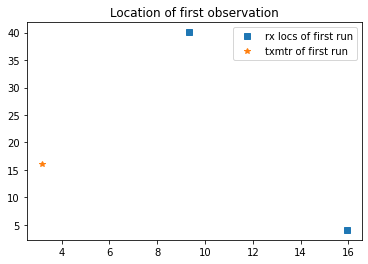

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=2, n_runs=10, rxtx_flag=2)

#get locations of Tx and Rx
locs = RFchannel_scenario1.rxtx_locs
print("Shape of output:",locs.shape)
plt.plot(locs[0,1:,0],locs[1,1:,0],'s',label='rx locs of first run')
plt.plot(locs[0,0,0], locs[1,0,0],'*',label='txmtr of first run')
plt.title('Location of first observation')
plt.legend()
plt.show()

In [ ]:
show_doc(RFchannel.calculate_Rxxdelay)

<h4 id="RFchannel.calculate_Rxxdelay" class="doc_header"><code>RFchannel.calculate_Rxxdelay</code><a href="__main__.py#L187" class="source_link" style="float:right">[source]</a></h4>

> <code>RFchannel.calculate_Rxxdelay</code>(**`ch_delay_flag`**=*`1`*, **`tdoa_flag`**=*`1`*, **`seed`**=*`None`*)

Calculates relative delay of wireless signals from a
transmitter (Tx) to different receivers (Rx) based on given Rx
and Tx locations for each run/observation. Assumes structure of
first column is Tx, rest of columns are Rx. Third dimension is
multiple runs of data (see `generate_RxTxlocations`). These 
relative delays are time delay estimates (TDE's).

Time related variables are assumed to be nanoseconds in
PoissonArray, time intervals are normalized to same.  Note that
rxtx_locations is given in meters.  Perturbs the ideal TDE 
based on given statistical distribution(s) parameterized by
values in PoissonArray.  In other words, describes impairments
caused by multipath in a statistical sense ([^4]).

__Parameters__

>__ch_delay_flag__ : Integer/boolean, default=1
>- Channel flag whether to add multipath (random) based on 
>PoissonArray parameters. 
>    - 0 - return ideal delays (absolute
>or differential) 
>    - 1 (default) - return random offsets 
>characterized by poissonarray parameters
>
>__tdoa_flag__ : Integer/boolean, default=1 
>- Type of measurement to return,
>    - 0 - rtn abs time of flight (i.e. ToF) between Tx and Rx.
>    - 1-(default)- returns differential time (i.e., TDOA) between
>        pairs of sensors of format (rx1-rx2, rx1-rx3,... rx1-rxn, 
>        rx2-rx3,..., rx(n-1) - rxn
>
>__rxtx_locations__ : ndarray, self.rxtx_locs_  
>- *set by class instantiation*
>- Format of [location dims] x [num_rx + 1] x [num_runs] array
>
>__poissonarray__ : list,[maxSpreadT, PoissonInvLambda, Poissoninvlambda, PoissonGamma, Poissongamma] 
>- *set by class instantiation*
>- List of time-related propagation parameters in integers
>    (nanosecond units)
>
>__seed__ : integer, default=None
>- set for reprodducible results

__Returns__

>Self, sets self.rxx_delay
>- Format is [num_runs] x [abs (num_rx)/diff delay measurements 
>(num_rx choose 2)] - units of nanoseconds

__Notes__

[^4]: A. A. M. Saleh and R. Valenzuela, "A Statistical Model for
    Indoor Multipath Propagation," in IEEE Journal on Selected 
    Areas in Communications, vol. 5, no. 2, pp. 128-137, February
    1987, doi: 10.1109/JSAC.1987.1146527.

---
#### calculate_Rxxdelay Examples

The following shows 10 examples of time delay measurements of signal recieved at 2ea receivers (Rx) as transmited by 1ea (Tx) within a 20x60m area.  Emperically derived paramters, by Saleh, that describe the multipath distribution are provided.

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=2, n_runs=10, rxtx_flag=2)

#calculate delays (TDOA)
RFchannel_scenario1.calculate_Rxxdelay(ch_delay_flag=False)
rxx_delay_no_noise_TDOA = RFchannel_scenario1.rxx_delay

RFchannel_scenario1.calculate_Rxxdelay(ch_delay_flag=True)
rxx_delay_noise_TDOA = RFchannel_scenario1.rxx_delay

#pair of sensors returns 1ea differential value for each observation/run
print("    Observation #:",*('%3d'%x for x in range(RFchannel_scenario1.n_runs) ))
print("Ideal TDOA's (ns):",*('%3.0f'%x for x in rxx_delay_no_noise_TDOA))
print("Noisy TDOA's (ns):",*('%3.0f'%x for x in rxx_delay_noise_TDOA))


    Observation #:   0   1   2   3   4   5   6   7   8   9
Ideal TDOA's (ns): -77 -26 -14  25  88 -11  -6  55 -74  12
Noisy TDOA's (ns): -70 -26 -31  16  88  31   5  46 -74   7


---
The following example generates a set of observations and confirms distribution of measurement error.

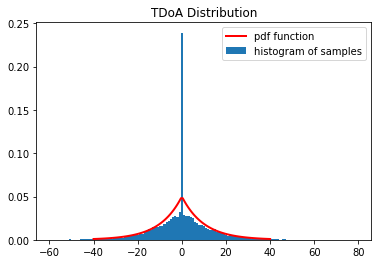

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()  
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=2, n_runs=10000, rxtx_flag=0) #fixed Tx

#calculate delays (TDOA)
rxx_delay_no_noise_TDOA = (RFchannel_scenario1.calculate_Rxxdelay(ch_delay_flag=False)).rxx_delay
rxx_delay_noise_TDOA = (RFchannel_scenario1.calculate_Rxxdelay(ch_delay_flag=True)).rxx_delay

#get difference (for error distribution)
diff = rxx_delay_no_noise_TDOA-rxx_delay_noise_TDOA

#plot histogram
_ = plt.hist(diff, bins='auto',density=True, label='histogram of samples')  # arguments are passed to np.histogram

#pdf
from scipy.stats import laplace
x=np.linspace(-40,40,100)
#scale and locate pdf
rv = laplace(loc=0,scale=RFchannel_scenario1.Poissoninvlambda)
#plot pdf
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='pdf function')
plt.title("TDoA Distribution")
plt.legend()
plt.show()

In [ ]:
show_doc(RFchannel.calculate_RxxRssi)

<h4 id="RFchannel.calculate_RxxRssi" class="doc_header"><code>RFchannel.calculate_RxxRssi</code><a href="__main__.py#L308" class="source_link" style="float:right">[source]</a></h4>

> <code>RFchannel.calculate_RxxRssi</code>(**`ch_gain_flag`**=*`1`*, **`drss_flag`**=*`0`*, **`seed`**=*`None`*)

Calculates absolute or relative received power at each sensor
(or pair of sensors) based on given Rx and Tx locations. Assumes
structure of first column is Tx, rest of columns are Rx. Third 
dimension is multiple runs of data (see 
`generate_RxTxlocations`).  Returns absolute received signal 
strength (RSS) or relative power (RSSI).

Received power is a log-normal Gaussian/Normal RV around a 
distance dependent mean ([^5]).

__Parameters__

>__ch_gain_flag__ : integer/boolean, default =1
>- Whether to add shadowing based on LogNormalArray parameters
>    - 0 - ideal free space loss
>    - 1 - (default) - shadowing path loss
>
>__drss_flag__ : integer/boolean, default=0
>- Type of measurement to return,
>    - 0 - (default) return RSS
>    - 1 - rtn differential RSS (n choose 2) between pairs of 
>    sensors of format (rx1-rx2, rx1-rx3,... rx1-rxn, 
>    rx2-rx3,..., rx(n-1) - rxn
>
>__rxtx_locations__ : ndarray, self.rxtx_locs_  
>- *set by class instantiation*
>-Format of [location dims] x [num_rx + 1] x [num_runs] array
>
>__LogNormalArray__ : list, 
>- *set by class instantiation*
>- List of RF channel parameters in relevant units:
>    [PathLossN, Xsigma, Wavelength] where PathLossN is path loss
>    exponent (ideal is 2) in dB, Xsigma is Std deviation of
>    received power in dB (log-normal Gaussian RV), Wavelength 
>    is of RF signal emanating from Tx source in Hz
>
>__seed__ : integer, default=None
>- set for reprodducible results

__Returns__

>Self, sets self.rxx_rssi
>- Format is [num_runs] x [abs (num_rx)/diff delay measurements 
>    (num_rx choose 2)] - units of dB

__Notes__

[^5]: Theodore S. Rappaport's Wireless Communications: Principles
    and Practice by IEEE Press, Inc. Prentic Hall ISBN: 
    0-7803-1167-1. Chapters 3 and 4

---
#### calculate_RxxRssi Examples

The following shows 10 examples of received signal strength measurements by 2ea receivers (Rx) of a signal transmited by 1ea (Tx) within a 20x60m area.  Emperically derived parameters, by Rappaport, that describe typical path loss distribution are provided.

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=2, n_runs=10, rxtx_flag=2)

#calculate received power (RSS)
RFchannel_scenario1.calculate_RxxRssi(ch_gain_flag=False)
rx_rssi_no_shadowing_RSS = RFchannel_scenario1.rxx_rssi
RFchannel_scenario1.calculate_RxxRssi(ch_gain_flag=True)
rx_rssi_shadowing_RSS = RFchannel_scenario1.rxx_rssi

#pair of sensors over 10 observations, pick sensor one to display
print("             Observation #:",*('%3d'%x for x in range(RFchannel_scenario1.n_runs) ))
print("Sensor1 - Ideal RSS's (dB):",*('%3.0f'%x for x in rx_rssi_no_shadowing_RSS[:,0]))
print("Sensor2 - Noisy RSS's (dB):",*('%3.0f'%x for x in rx_rssi_shadowing_RSS[:,0]))

             Observation #:   0   1   2   3   4   5   6   7   8   9
Sensor1 - Ideal RSS's (dB):  52  45  44  38  39  44  25  44  41  47
Sensor2 - Noisy RSS's (dB):  68  57  55  54  46  59  17  54  46  57


---
The following example generates a large number of samples and then inspects histogram of errors against expected log-normal Gaussian distribution (for here - normal distribution with units in dB).  


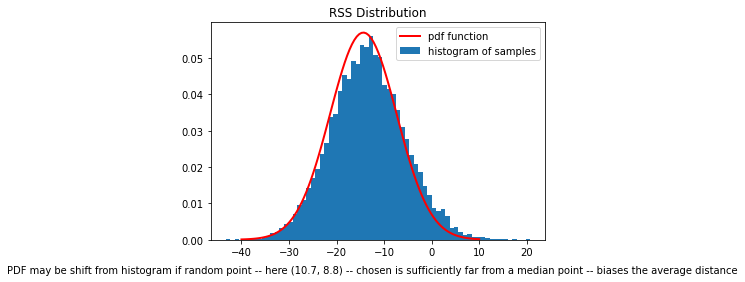

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=1, n_runs=10000, rxtx_flag=0)

#calculate received power (RSS)
rx_rssi_no_shadowing_RSS = (RFchannel_scenario1.calculate_RxxRssi(ch_gain_flag=False)).rxx_rssi
rx_rssi_shadowing_RSS = (RFchannel_scenario1.calculate_RxxRssi(ch_gain_flag=True)).rxx_rssi

#get difference (for error distribution)
diff = rx_rssi_no_shadowing_RSS-rx_rssi_shadowing_RSS

#plot histogram
fig = plt.figure()
_ = plt.hist(diff, bins='auto',density=True, label='histogram of samples')  # arguments are passed to np.histogram

#pdf
from scipy.stats import norm
x=np.linspace(-40,10,100)

#scale and locate pdf - fix offset due to reference value in path loss and distance
avg_dist = np.mean(np.linalg.norm(locs[:,1,:]-locs[:,0,1][:,np.newaxis],axis=0)) #get average distance
offset=-10*(RFchannel_scenario1.PathLossN-2)*np.log10(avg_dist) #calc avg offset based on distance PLE diff
rv = norm(loc=offset,scale=RFchannel_scenario1.Xsigma)

#plot pdf
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='pdf function')
plt.title("RSS Distribution")
plt.legend()
txt = "PDF may be shift from histogram if random point -- here ({:.1f}, {:.1f}) -- chosen is sufficiently far from a median point -- biases the average distance".format(locs[:,0,1][0],locs[:,0,1][1])
fig.text(.5, .01, txt, wrap=True, ha='center')
plt.show()


In [ ]:
show_doc(RFchannel.calculate_AoA)

<h4 id="RFchannel.calculate_AoA" class="doc_header"><code>RFchannel.calculate_AoA</code><a href="__main__.py#L405" class="source_link" style="float:right">[source]</a></h4>

> <code>RFchannel.calculate_AoA</code>(**`ch_angle_flag`**=*`1`*, **`daoa_flag`**=*`0`*, **`seed`**=*`None`*)

Calculates AoA based on given Rx and Tx locations. Assumes
structure of first column is Tx, rest of columns are Rx. Third
dimension is multiple runs of data.  For noisy case, ([^7]) 
assumes uniform distribution [0,2pi) of clusters, each cluster
has Laplacian distribution around a specific AoA with width 
just under 30 degrees.  Assumption is specular component (or 
strongest) mean value is correct value.

__Parameters__

>__ch_angle_flag__ : Integer/boolean, default=1
>- Flag whether to add multipath affect based on AoAsigma
>    parameters.  
>    - 0 - return ideal AoA (absolute or differential)
>    - 1 (default) - return random offsets characterized by
>    AoAsigma parameters  
>    
>__daoa_flag__ : integer/boolean, default=0
>- Type of measurement to return,
>    - 0 - (default) return AoA
>    - 1 - rtn differential AoA (n choose 2) between pairs of
>    sensors of format (rx1-rx2, rx1-rx3,... rx1-rxn, 
>    rx2-rx3,..., rx(n-1) - rxn
>
>__rxtx_locations__ : ndarray, self.rxtx_locs_  
>- *set by class instantiation*
>- Format of [location dims] x [num_rx + 1] x [num_runs] array
>
>__AoAArray__ : list, self.AoAsigma
>- *set by class instantiation*
>- List of RF channel parameters in relevant units: [AoAsigma]
>    which is Laplacian standard deviation of angle of arrival 
>    error in radians of RF signal emanating from Tx source 
>
>__seed__ : integer, default=None
>- set for reprodducible results

__Returns__

>Self, sets self.rxx_rssi
>- Format is [num_runs] x [abs (num_rx)/diff angle measurements 
>    (num_rx choose 2)] - units of radians

__Notes__

[^7]: Q. H. Spencer, B. D. Jeffs, M. A. Jensen and A. L. 
    Swindlehurst, "Modeling the statistical time and angle of 
    arrival characteristics of an indoor multipath channel," in
    IEEE Journal on Selected Areas in Communications, vol. 18, no. 
    3, pp. 347-360, March 2000, doi: 10.1109/49.840194.   

---
#### calculate_AoA Examples

The following example shows 10 examples of angle of arrival measurements by 2ea receivers (Rx) of a signal transmited by 1ea (Tx) within a 20x60m area.  Emperically derived paramters, by Spencer, that describe typical angle of arrival distribution are provided.


In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=2, n_runs=10, rxtx_flag=2)

#calculate angle of arrival (AoA)
RFchannel_scenario1.calculate_AoA(ch_angle_flag=False)
rx_ideal_aoa = RFchannel_scenario1.rxx_aoa

RFchannel_scenario1.calculate_AoA(ch_angle_flag=True)
rx_noisy_aoa = RFchannel_scenario1.rxx_aoa

#pair of sensors over 10 observations, pick sensor one to display
print("            Observation #:",*('%5d'%x for x in range(RFchannel_scenario1.n_runs) ))
print("Sensor1 - Ideal AoA (rad):",*('%+2.2f'%x for x in rx_ideal_aoa[:,0]))
print("Sensor2 - Noisy AoA (rad):",*('%+2.2f'%x for x in rx_noisy_aoa[:,0]))

            Observation #:     0     1     2     3     4     5     6     7     8     9
Sensor1 - Ideal AoA (rad): +1.90 +2.12 +3.00 -0.87 -1.44 -1.05 -2.21 +1.13 -1.36 +1.53
Sensor2 - Noisy AoA (rad): +3.20 +2.33 +2.83 -1.17 -1.50 -0.90 -1.74 +1.39 -1.95 +1.06


---
The following example generates a large number of samples and then inspects histogram of errors against expected Laplacian distribution.  


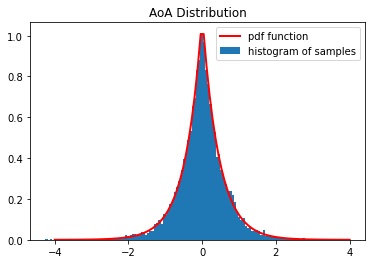

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=1, n_runs=10000, rxtx_flag=0) #fixed Tx

#calculate angle of arrival (AoA)
rx_ideal_aoa = (RFchannel_scenario1.calculate_AoA(ch_angle_flag=False)).rxx_aoa
rx_noisy_aoa = (RFchannel_scenario1.calculate_AoA(ch_angle_flag=True)).rxx_aoa

#get difference (for error distribution)
diff = rx_ideal_aoa-rx_noisy_aoa

#plot histogram
_ = plt.hist(diff, bins='auto',density=True, label='histogram of samples')  # arguments are passed to np.histogram

#pdf
from scipy.stats import laplace
x=np.linspace(-4,4,100)
#scale and locate pdf
rv = laplace(loc=0,scale=RFchannel_scenario1.AoAsigma)
#plot pdf
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='pdf function')
plt.title("AoA Distribution")
plt.legend()
plt.show()

In [ ]:
show_doc(RFchannel.generate_Xmodel)

<h4 id="RFchannel.generate_Xmodel" class="doc_header"><code>RFchannel.generate_Xmodel</code><a href="__main__.py#L492" class="source_link" style="float:right">[source]</a></h4>

> <code>RFchannel.generate_Xmodel</code>(**`ch_delay_flag`**=*`1`*, **`ch_gain_flag`**=*`1`*, **`ch_angle_flag`**=*`1`*, **`meas_flag`**=*`6`*, **`diff_array`**=*`[1, 0, 0]`*, **`seed`**=*`None`*)

Generates a set of measurements based on passed parameters 
that can be used for a dictionary or training/testing of 
different optimization algorithms.

___Parameters___

>__rxtx_locations__ : ndarray, self.rxtx_locs_  
>- *set by class instantiation*
>- Format of [location dims] x [num_rx + 1] x [num_runs] array
>
>__poissonarray__ : list, default=[maxSpreadT, PoissonInvLambda, Poissoninvlambda, PoissonGamma, Poissongamma] 
>- *set by class instantiation*
>- List of time-related propagation parameters in integers
>    (nanosecond units)
>
>__ch_delay_flag__ : Integer/boolean, default=1
>- Channel flag whether to add multipath (random) based on 
>    PoissonArray parameters.
>    - 0 - return ideal delays (absolute
>    - or differential) 1 (default) - return random offsets 
>    characterized by poissonarray parameters
>
>__LogNormalArray__ : list, default=[PathLossN, Xsigma, Wavelength]
>- *set by class instantiation*
>- List of RF channel parameters in relevant units:
>     where PathLossN is path loss
>    exponent (ideal is 2) in dB, Xsigma is Std deviation of
>    received power in dB (log-normal Gaussian RV), Wavelength 
>    is of RF signal emanating from Tx source in Hz
>
>__ch_gain_flag__ : integer/boolean, default =1
>- Whether to add shadowing based on LogNormalArray parameters
>    - 0 - ideal free space loss
>    - 1 - (default) - shadowing path loss
> 
>__AoAArray__ : list, self.AoAsigma
>- *set by class instantiation*
>- List of RF channel parameters in relevant units: [AoAsigma]
>    which is Laplacian standard deviation of angle of arrival 
>    error in radians of RF signal emanating from Tx source
>    
>__ch_angle_flag__ : Integer/boolean, default=1
>- Flag whether to add multipath affect based on AoAsigma
>    parameters.  
>    - 0 - return ideal AoA (absolute or differential)
>    - 1 (default) - return random offsets characterized by
>    AoAsigma parameters  
>
>__meas_flag__ : Integer, default=6
>    - Determines which measurement types are generated for
>    a given channel.  Options are: 
>        - 0-tdoa, 
>        - 1-drss, 
>        - 2-aoa,
>        - 3-tdoa/drss, 
>        - 4-tdoa/aoa, 
>        - 5-drss/aoa, 
>        - 6-tdoa/drss/aoa
>            
>__diff_array__ : Boolean list, default = [1,0,0] 
>- List sets whether measurement types are differential or 
>    absolute measurements for TDOA, RSS, and AoA, e.g.,
>    - [1,0,0] - TDOA, RSS, and AoA
>    - [1,1,0] - TDOA, DRSS, and AoA
>    - [1,1,1] - TDOA, DRSS, and DAoA
>    - [tdoa_flag, drss_flag, daoa_flag]
>
>__seed__ : integer, default=None
>- set for reprodducible results        

___Returns___

>Self, sets self.X_model
>- Format is [n_runs]x[measurements] (sized set by meas_flag,
>    diff_array parameters) 

---
#### generate_Xmodel Example

The following illustrates using a single method to generate a set of measurements, i.e., dictionary, using any combination of the covered TDoA, RSS, and AoA methods.  Note that parameters to generate_Xmodel are the same.

In [ ]:
#generate channel scenario
RFchannel_scenario1 = RFchannel()
#from channel, generate locations for Tx and Rx
RFchannel_scenario1.generate_RxTxlocations(n_rx=3, n_runs=10, rxtx_flag=0)

#create set of measurements
RFchannel_scenario1.generate_Xmodel(ch_delay_flag=1, ch_gain_flag=1, ch_angle_flag=1, 
                        meas_flag=6, diff_array= [1,0,0])

#pull out full set of measurements from instance
X = RFchannel_scenario1.X_model

num_rx=RFchannel_scenario1.n_rx
#3ea sensors over 10 observations, generate TDOA, RSS, and AoA
print("       ",*('TDoA%d:%d'%x for x in combinations(range(num_rx),2) ),*('   RSS%d'%x for x in range(num_rx)),*('   AoA%d'%x for x in range(num_rx)))
for i in range(RFchannel_scenario1.n_runs):    
    print("obs {:d}: ".format(i),*('{0:+7.2f}'.format(x) for x in X[i]))


        TDoA0:1 TDoA0:2 TDoA1:2    RSS0    RSS1    RSS2    AoA0    AoA1    AoA2
obs 0:  +117.77  +85.69  -32.08  +59.77  +19.01  +46.02   +1.53   +2.96   +1.43
obs 1:   -66.41 -165.88  -99.47  +37.58  +65.72  +67.42   +0.66   +1.68   +1.43
obs 2:   +87.25  +78.33   -8.91  +66.54  +60.11  +62.02   +1.77   +1.79   +1.70
obs 3:   +42.91  -38.26  -81.17  +54.16  +32.58  +70.58   +1.38   -1.66   +1.69
obs 4:   +76.21  -17.05  -93.26  +74.65  +48.64  +85.26   +1.34   +3.99   +1.49
obs 5:  -130.17 -147.57  -17.40  +28.57  +58.01  +66.60   +0.69   +0.90   +1.65
obs 6:   +26.83  +39.46  +12.63  +65.20  +64.41  +54.35   +0.92   +2.06   +1.83
obs 7:    -7.41  +80.33  +87.74  +86.03  +70.87  +61.53   +2.15   +1.74   +2.33
obs 8:   +73.13 +133.10  +59.98  +65.34  +55.59  +48.81   +1.38   +2.80   +0.56
obs 9:   -60.54  +24.63  +85.17  +54.46  +68.63  +62.59   +1.88   +1.48   +1.84
